**Phishing** é como uma armadilha disfarçada na sua caixa de entrada: e-mails que parecem legítimos, mas escondem a intenção de roubar dados ou instalar algo malicioso.  
> Basta um clique descuidado para “morder a isca”.

Neste notebook, vamos criar uma **classificação simples** para identificar **e-mails de phishing** usando **Regressão Logística**.  
A ideia é ensinar um modelo a diferenciar mensagens legítimas de armadilhas digitais, ajudando a detectar quando alguém tenta “pescar” suas informações.
Não vamos lidar com **URLs** aqui, mas, ao final do projeto, vou deixar links para artigos interessantes sobre o tema para quem quiser se aprofundar.

[Assista ao vídeo no YouTube sobre Phishing se quiser ter mais um pouco de contexto](https://www.youtube.com/watch?v=Y7zNlEMDmI4)


In [ ]:
import re
import joblib
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


No decorrer do notebook, vou explicar melhor cada uma!

**Bibliotecas utilizadas:**

- `re` → Expressões regulares para limpeza e manipulação de texto.  
- `joblib` → Salvar e carregar modelos treinados de forma eficiente.  
- `numpy` → Operações matemáticas e vetoriais.  
- `pandas` → Manipulação e análise de dados em tabelas (DataFrames).  
- `matplotlib.pyplot` → Criação de gráficos.  
- `seaborn` → Visualizações estatísticas com estilo aprimorado.  

**Scikit-learn:**
- `LogisticRegression` → Modelo de classificação binária.  
- `TfidfVectorizer` → Transforma texto em vetores usando frequência e relevância de palavras.  
- `train_test_split` → Divide dados em treino e teste.  
- `GridSearchCV` → Busca pelos melhores hiperparâmetros.  
- `Pipeline` → Encadeia etapas de pré-processamento e modelagem.  
- `CountVectorizer` → Converte texto em vetores baseados na contagem de palavras.  
- `LatentDirichletAllocation` → Descoberta de tópicos em textos (LDA).  

**NLTK:**
- `PorterStemmer` → Reduz palavras à sua raiz (stemming).  
- `stopwords` → Lista de palavras comuns a serem removidas do texto.


**Dataset do projeto:** [Clique aqui para acessar](https://huggingface.co/datasets/zefang-liu/phishing-email-dataset/tree/main)


### Uma humilde análise do dataset

In [ ]:
df = pd.read_csv('Phishing_Email.csv')
df.shape

(18650, 3)

Aqui estamos mapeando os valores da coluna 'Email Type' para números 0 para 'Safe Email' e 1 para 'Phishing Email'

In [ ]:
df['Email Type'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1 })
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,1,the other side of * galicismos * * galicismo *...,0
2,2,re : equistar deal tickets are you still avail...,0
3,3,\nHello I am your hot lil horny toy.\n I am...,1
4,4,software at incredibly low prices ( 86 % lower...,1


Removemos qualquer email com texto ausente

In [ ]:
df = df.dropna(subset=['Email Text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18634 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18634 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18634 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 582.3+ KB


Exibindo a distribuição de tipos de email




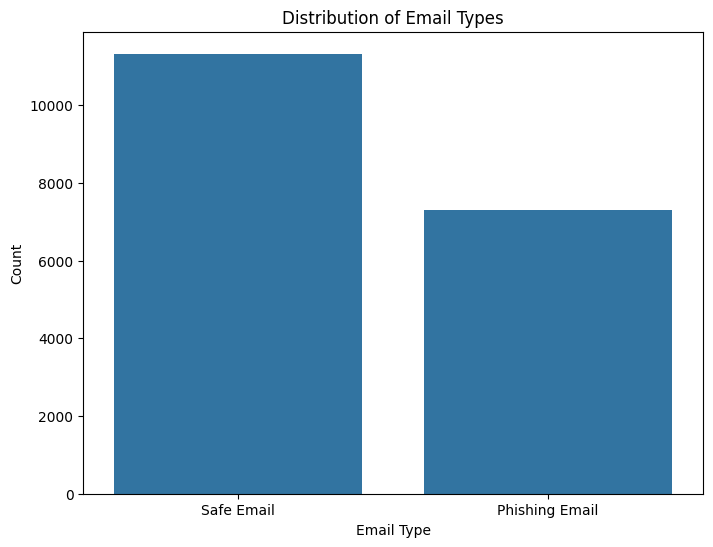

In [ ]:
email_type_counts = df['Email Type'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=email_type_counts.index, y=email_type_counts.values)
plt.xticks(ticks=[0, 1], labels=['Safe Email', 'Phishing Email'])
plt.title('Distribution of Email Types')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

### Técnicas de pré-processamento do Texto

In [ ]:
def preprocess_text(text):
  text = str(text)
  text = text.replace('\n', ' ')

  text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
  return text

In [ ]:
df['Email Text'] = df['Email Text'].apply(preprocess_text)
display(df.head())

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,1,the other side of * galicismos * * galicismo *...,0
2,2,re : equistar deal tickets are you still avail...,0
3,3,Hello I am your hot lil horny toy. I am t...,1
4,4,software at incredibly low prices ( 86 % lower...,1


1. **Tokenização (`tokenizer`)**  
   - Divide o texto em palavras (tokens) usando o espaço como separador.  
   - Exemplo: `"Adoro comer batata e salsicha"` → `["Adoro", "comer", "batata", "e", "salsicha"]`.  

In [ ]:
def tokenizer(text):
  return text.split()

tokenizer('Adoro comer batata e salsicha')

['Adoro', 'comer', 'batata', 'e', 'salsicha']

2. **Tokenização com stemming (`tokenizer_porter`)**  
   - Além de dividir o texto em palavras, aplica o **Porter Stemmer** para reduzir cada palavra à sua raiz.  
   - Exemplo: `"running"`, `"runs"` → `"run"`.  


In [ ]:
porter = PorterStemmer()

def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

tokenizer_porter('A runner likes running and runs a lot')


['a', 'runner', 'like', 'run', 'and', 'run', 'a', 'lot']

3. **Remoção de stopwords**  
   - Elimina palavras muito comuns (como *and*, *the*, *is*) que não agregam significado para a análise.  
   - Exemplo: `["runner", "likes", "running", "runs", "lot"]` → remove as stopwords e mantém apenas termos relevantes.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = stopwords.words('english')
[w for w in tokenizer_porter('A runner likes running and runs a lot') if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

### Dividindo o Dataset em Treino/Teste, setando a nossa pipeline de treino e os parametros do grid search.


In [ ]:
X = df['Email Text']
y = df['Email Type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

small_param_grid = [{
    'vect__ngram_range': [(1, 1)],
    'vect__stop_words': [None],
    'vect__tokenizer': [tokenizer, tokenizer_porter],
    'clf__penalty': ['l2'],
    'clf__C': [1.0, 10.0]
},{
    'vect__ngram_range': [(1, 1)],
    'vect__stop_words': [stop, None],
    'vect__tokenizer': [tokenizer],
    'vect__use_idf':[False],
    'vect__norm':[None],
    'clf__penalty': ['l2'],
    'clf__C': [1.0, 10.0]
}]

In [ ]:
lr_tfidf = Pipeline([('vect', tfidf),('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=1)

gs_lr_tfidf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   6.0s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   4.9s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   6.1s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.6min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__stop_words=None, vect__tokenizer=<function tokenizer_porter at 0x78da8d9eb9c0>; total time= 1.7min


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'o

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'o

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'o

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'o

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'o

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  11.8s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  13.8s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  12.0s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  12.3s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=1.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  16.3s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', '

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', '

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', '

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', '

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', '

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  12.8s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  13.9s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  13.3s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  12.9s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10.0, clf__penalty=l2, vect__ngram_range=(1, 1), vect__norm=None, vect__stop_words=None, vect__tokenizer=<function tokenizer at 0x78da8d9eb6a0>, vect__use_idf=False; total time=  15.9s


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=1,
             param_grid=[{'clf__C': [1.0, 10.0], 'clf__penalty': ['l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [None],
                          'vect__tokenizer': [<function tokenizer at 0x78da8d9eb6a0>,
                                              <function tokenizer_porter at 0x78da8d9eb9c0>...
                          'vect__stop_words': [['a', 'about', 'above', 'after',
                                                'again', 'against', 'ain',
                                                'all', 'am', 'an', 'and', 'any',
                                                'are', 'aren', "aren't", 'as',
                                                'at', 'be', 'because', 'been',
                                                'before', 'being', 'below',
                                                'between', 'both', 'but', 'by',
                                                'can', 'couldn', "couldn't", ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x78da8d9eb6a0>],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=2)

Uma vez que o treinamento foi concluído, podemos checar quais foram os melhores parametros para o modelo

In [ ]:
print(gs_lr_tfidf.best_params_)

{'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x78da8d9eb6a0>}


In [ ]:
print(f'CV Accuracy: {gs_lr_tfidf.best_score_:.3f}')

clf = gs_lr_tfidf.best_estimator_
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')


CV Accuracy: 0.972
Test Accuracy: 0.973


### Testando e salvando o modelo

Aqui temos um pequeno teste do modelo

In [ ]:
new_email_text = "Just a friendly reminder about our meeting scheduled for tomorrow at 10 AM in the conference room."

cleaned_new_email_text = preprocess_text(new_email_text)

prediction = clf.predict([cleaned_new_email_text])

if prediction[0] == 0:
    result = 'Safe Email'
else:
    result = 'Phishing Email'

print(f"The email is classified as: {result}")

The email is classified as: Safe Email


In [ ]:
model_filename = 'phishing_email_model.pkl'

joblib.dump(clf, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to phishing_email_model.pkl


### Tentando aplicar uma LDA para identificar tópicos no dataset

In [ ]:
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,1,the other side of * galicismos * * galicismo *...,0
2,2,re : equistar deal tickets are you still avail...,0
3,3,Hello I am your hot lil horny toy. I am t...,1
4,4,software at incredibly low prices ( 86 % lower...,1


In [ ]:
df = df.rename(columns={"0": "Email Text", "1": "Email Type"})
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,1,the other side of * galicismos * * galicismo *...,0
2,2,re : equistar deal tickets are you still avail...,0
3,3,Hello I am your hot lil horny toy. I am t...,1
4,4,software at incredibly low prices ( 86 % lower...,1


In [ ]:
count = CountVectorizer(stop_words="english", max_df=.1, max_features=5000)


X = count.fit_transform(df["Email Text"].values)

In [ ]:
lda = LatentDirichletAllocation(n_components=10, random_state=123, learning_method="batch")

X_topics = lda.fit_transform(X)

In [ ]:
lda.components_.shape

(10, 5000)

In [ ]:
n_top_words = 5
features_name = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
  print(f'Topic {(topic_idx + 1)}:')
  print(' '.join([features_name[i]for i in topic.argsort() \
                                           [:-n_top_words - 1:-1]]))

Topic 1:
ect hou vince 2000 cc
Topic 2:
university language linguistics conference papers
Topic 3:
½ï company said energy stock
Topic 4:
languages english money book language
Topic 5:
000 report money program font
Topic 6:
2001 01 gas pm original
Topic 7:
software online site web internet
Topic 8:
linux users lists spamassassin org
Topic 9:
language perl org 02 hour
Topic 10:
3d addresses links internet directory


In [ ]:
financial_services = X_topics[:, 5].argsort()[::-1]
for iter_idx, movie_idx in enumerate(financial_services[:3]):
    print(f'\nFinancial #{(iter_idx + 1)}:')
    print(df['Email Text'][movie_idx][:100], '...')


Financial #1:
At 08:58 AM 7/23/02 -0700, Joseph S. Barrera III wrote:>And you. I especially hate you.Heh. The name ...

Financial #2:
[ mpiro ] for your benefit dont ignore this very important message . . . dear homeowner , you have b ...

Financial #3:
URL: http://www.newsisfree.com/click/-1,8394718,1717/ Date: 2002-09-30T14:13:10+01:00(Some Dysfuncti ...


### Teste final rodando 5 textos diferentes

In [37]:

sentences_to_classify = [
    "Click here to claim your free prize now!",
    "Meeting scheduled for tomorrow at 2 PM.",
    "Urgent: Your account has been compromised. Verify your details immediately.",
    "Please review the attached document.",
    "You've won a lottery! Provide your bank details to receive the prize."
]

for sentence in sentences_to_classify:
  clean_sentence = preprocess_text(sentence)
  prediction = clf.predict([clean_sentence])

  if prediction[0] == 0:
    result = 'Safe Email'
  else:
    result = 'Phishing Email'
  print(f"Sentence: '{sentence}'")
  print(f"Classification: {result}\n")

Sentence: 'Click here to claim your free prize now!'
Classification: Phishing Email

Sentence: 'Meeting scheduled for tomorrow at 2 PM.'
Classification: Safe Email

Sentence: 'Urgent: Your account has been compromised. Verify your details immediately.'
Classification: Phishing Email

Sentence: 'Please review the attached document.'
Classification: Safe Email

Sentence: 'You've won a lottery! Provide your bank details to receive the prize.'
Classification: Phishing Email



Peguei dois exemplos da https://security.berkeley.edu/education-awareness/phishing/phishing-examples-archive

In [41]:
sentences_from_security_barkeleyU = [
    "Dear Berkeley Team,We are upgrading our email security to better protect your account. To ensure a seamless transition, please accept the new terms and conditions.Accept New Terms.",
    "I hope this message finds you in good health. I wanted to reach out to discuss a pressing health matter concerning our University of California Berkeley community. Recently, we've identified a case of a COVID-19 variant among our staff. Despite the high vaccination rates within our community, some variants can still pose risks, even to those who are vaccinated. As a precautionary measure, we're actively conducting thorough contact tracing to swiftly identify and address any potential exposure risks. Your cooperation is crucial in this endeavor. We kindly request you to check if you've had any recent contact with the affected staff member. For your convenience, we've created a dedicated webpage where you can find more information and report any contact. Please visit the webpage here: Access Team Member Profiles <hxxps://rjllegal.com/auth.berkeley.edu/>. Your timely response is essential to safeguarding the health and safety of our community. If you have any concerns or queries, our medical team is available to assist you. You can contact them at Healthcarecenter@berkeley.edu(link sends e-mail). We're fully committed to maintaining a safe environment and deeply appreciate your cooperation in these efforts. Please remember that this message is confidential and intended solely for you; kindly refrain from sharing or forwarding it.",
]

for sentence in sentences_from_security_barkeleyU:
  clean_sentence = preprocess_text(sentence)
  prediction = clf.predict([clean_sentence])

  if prediction[0] == 0:
    result = 'Safe Email'
  else:
    result = 'Phishing Email'
  print(f"Sentence: '{sentence}'")
  print(f"Classification: {result}\n")

Sentence: 'Dear Berkeley Team,We are upgrading our email security to better protect your account. To ensure a seamless transition, please accept the new terms and conditions.Accept New Terms.'
Classification: Phishing Email

Sentence: 'I hope this message finds you in good health. I wanted to reach out to discuss a pressing health matter concerning our University of California Berkeley community. Recently, we've identified a case of a COVID-19 variant among our staff. Despite the high vaccination rates within our community, some variants can still pose risks, even to those who are vaccinated. As a precautionary measure, we're actively conducting thorough contact tracing to swiftly identify and address any potential exposure risks. Your cooperation is crucial in this endeavor. We kindly request you to check if you've had any recent contact with the affected staff member. For your convenience, we've created a dedicated webpage where you can find more information and report any contact. P

  ### Extra: Algumas paradas interessantes sobre o Tema


Vou usar essa sessão para indicar alguns materiais interessantes sobre classificacão de Phishing usando Machine learning e Deep learning.



#### Artigos Acadêmicos e Teses

- [Detection of Phishing Websites using Machine Learning Approaches](https://ieeexplore.ieee.org/document/9617482)  
  Estudo que explora técnicas de aprendizado de máquina para detectar sites de phishing.

- [Detecting Phishing Emails Using Machine Learning Techniques (Tese de Mestrado - Middle East University)](https://www.meu.edu.jo/libraryTheses/590422b4d5dd8_1.pdf)  
  Tese de mestrado que investiga a detecção de e-mails de phishing utilizando técnicas de aprendizado de máquina.

- [Naive Bayes and Text Classification I, Introduction and Theory](https://arxiv.org/pdf/1410.5329v3)  
  Artigo que aborda a teoria e a aplicação do classificador Naive Bayes em tarefas de classificação de texto.

#### Códigos e Implementações Práticas

- [p_email.py (exemplo usando Naive Bayes Multinomial)](https://github.com/asimcode2050/Asim-Code-Youtube-Channel-Code/blob/main/Digital%20forensics/p_email.py)  
  Script que utiliza o classificador Naive Bayes Multinomial para detectar e-mails de phishing.

- [Phishing Website Detection by Machine Learning Techniques (Projeto Final do Curso de IA & Cibersegurança)](https://github.com/shreyagopal/Phishing-Website-Detection-by-Machine-Learning-Techniques/blob/master/Phishing%20Website%20Detection_Models%20%26%20Training.ipynb)  
  Projeto final que treina modelos de aprendizado de máquina e redes neurais profundas para prever sites de phishing.

#### Artigos Comparativos

- [Advancing Phishing Email Detection: A Comparative Study of Deep Learning Models](https://www.mdpi.com/1424-8220/24/7/2077)  
  Estudo comparativo que avalia o desempenho de diferentes modelos de deep learning na detecção de e-mails de phishing.
